# Images multi-label classification using Keras
---

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import glob
from PIL import Image
import os

from tqdm.notebook import tqdm
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape

Using TensorFlow backend.
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jakub/Dokumenty/venv36/lib/pytho

In [2]:
print('Tensorflow:', tf.__version__)

Tensorflow: 2.0.0-beta1


In [3]:
pd.set_option('display.max_colwidth', 400)

## Data loading
---

### Gather valid data

In [4]:
jpg_files = sorted(glob.glob('ml_class_images/Multi_Label_dataset/Images/*'))
f'Images: {len(jpg_files)}'

'Images: 7867'

In [5]:
y_df = pd.read_csv('ml_class_images/Multi_Label_dataset/train.csv').sort_values('Id')
y_df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
98,tt0084058,"['Drama', 'Romance']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
80,tt0084867,"['Action', 'Crime', 'Thriller']",1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
62,tt0085121,"['Crime', 'Drama', 'Thriller']",0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
37,tt0085154,"['Drama', 'Romance', 'Sport']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
69,tt0085159,['Horror'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
classes = y_df.iloc[:,2:].columns.values
classes

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

In [7]:
f'Labels: {len(y_df.index)}'

'Labels: 7254'

It looks like some images remain unannotated and some annotaions do not have its own image. It is needed to delete these examples.

In [8]:
jpg_ids = np.array([jpg_file.split('/')[-1].replace('.jpg', '') for jpg_file in jpg_files])
paired = np.intersect1d(jpg_ids, y_df['Id'].values)
paired

array(['tt0084058', 'tt0084867', 'tt0085121', ..., 'tt4179482',
       'tt4294084', 'tt4425258'], dtype=object)

In [9]:
jpg_files_red = np.vectorize(lambda p: f'ml_class_images/Multi_Label_dataset/Images/{p}.jpg')(paired)
y_df_red = y_df.drop_duplicates()

### Load valid data

In [10]:
# calculate maximum height and width of images
if not os.path.exists('ml_class_images/X_data.npy'):
    max_w, max_h = 0, 0
    for jpg_file in tqdm(jpg_files_red):
        img = Image.open(jpg_file)
        img.load()
        img_data = np.asarray(img)
        w, h, _ = img_data.shape
        if w > max_w:
            max_w = w
        if h > max_h:
            max_h = h
    print(f'Maximum dimensions: {max_w, max_h}')

In [11]:
# load data of equalized shapes
if not os.path.exists('ml_class_images/X_data.npy'):
    X = list([])
    for jpg_file in tqdm(jpg_files_red):
        img = Image.open(jpg_file)
        img = img.resize((max_h, max_w), Image.ANTIALIAS)
        img.load()
        X.append(np.asarray(img))
    np.save('ml_class_images/X_data.npy', np.array(X))
else:
    X = np.load('ml_class_images/X_data.npy')

In [12]:
X = np.array(X)
prim_X_shape = X.shape[1:]
print(f'Primary X shape: {prim_X_shape}')
X = X.reshape(-1, prim_X_shape[0]*prim_X_shape[1]*prim_X_shape[2])
X.shape

Primary X shape: (581, 300, 3)


(7242, 522900)

In [13]:
if not os.path.exists('ml_class_images/y_data.npy'):
    y = y_df_red.iloc[:,2:].values
    np.save('ml_class_images/y_data.npy', y)
else:
    y = np.load('ml_class_images/y_data.npy')
y.shape

(7242, 25)

In [14]:
# delete redundant variables
del jpg_files
del jpg_files_red
del y_df
del y_df_red

## Classs weighting
---
Dealing with imbalanced classes.

In [15]:
counts = np.array(np.sum(y, axis=0)).flatten()
counts

array([1339,  868,  244,  441, 2895, 1175,  650, 3617,  434,  467,  224,
        502,  304,   97,  453,    9,   21,    2, 1331,  397,   46,  219,
        916,  144,   50])

In [16]:
weights = np.array([np.size(counts)/np.float32(c) for c in counts])
weights

array([1.86706497e-02, 2.88018433e-02, 1.02459016e-01, 5.66893424e-02,
       8.63557858e-03, 2.12765957e-02, 3.84615385e-02, 6.91180536e-03,
       5.76036866e-02, 5.35331906e-02, 1.11607143e-01, 4.98007968e-02,
       8.22368421e-02, 2.57731959e-01, 5.51876380e-02, 2.77777778e+00,
       1.19047619e+00, 1.25000000e+01, 1.87828700e-02, 6.29722922e-02,
       5.43478261e-01, 1.14155251e-01, 2.72925764e-02, 1.73611111e-01,
       5.00000000e-01])

In [17]:
class_weight = dict({i: w for i, w in enumerate(weights)})

## Model
---

In [18]:
TRAIN_RATIO, TEST_RATIO = 0.6, 0.7

In [19]:
X_train, X_val, X_test = X[:int(len(X)*TRAIN_RATIO)], X[int(len(X)*TRAIN_RATIO):int(len(X)*TEST_RATIO)], X[int(len(X)*TEST_RATIO):]
y_train, y_val, y_test = y[:int(len(y)*TRAIN_RATIO)], y[int(len(y)*TRAIN_RATIO):int(len(y)*TEST_RATIO)], y[int(len(y)*TEST_RATIO):]

print(f'X_train: {X_train.shape} | y_train: {y_train.shape}')
print(f'X_val: {X_val.shape} | y_val: {y_val.shape}')
print(f'X_test: {X_test.shape} | y_test: {y_test.shape}')

X_train: (4345, 522900) | y_train: (4345, 25)
X_val: (724, 522900) | y_val: (724, 25)
X_test: (2173, 522900) | y_test: (2173, 25)


In [20]:
INIT = 'random_uniform'
LR = 0.001
BATCH_SIZE = 128
EPOCHS = 10

In [21]:
inputs = Input(shape=(522900,), name='images')
h = Reshape(prim_X_shape, name='input_reshaper')(inputs)
h = Conv2D(10, (3, 3), activation='relu', name='conv1d_0', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = MaxPool2D(pool_size=(2, 2), name='pool2d_0')(h)
h = Conv2D(10, (3, 3), activation='relu', name='conv1d_1', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = MaxPool2D(pool_size=(2, 2), name='pool2d_1')(h)
h = Conv2D(10, (3, 3), activation='relu', name='conv1d_2', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = MaxPool2D(pool_size=(2, 2), name='pool2d_2')(h)
h = Dropout(0.1, name='dropout_0')(h)
h = Flatten(name='flattener')(h)
h = Dense(120, activation='relu', name='dense_0', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dense(120, activation='relu', name='dense_1', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dense(50, activation='relu', name='dense_2', kernel_initializer=INIT, bias_initializer=INIT)(h)
h = Dropout(0.1, name='dropout_1')(h)
outputs = Dense(25, activation='sigmoid', name='predictions', kernel_initializer=INIT, bias_initializer=INIT)(h)

NN = Model(inputs=inputs, outputs=outputs, name='images_multilabel_classifier')

In [22]:
NN.summary()

Model: "images_multilabel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 522900)]          0         
_________________________________________________________________
input_reshaper (Reshape)     (None, 581, 300, 3)       0         
_________________________________________________________________
conv1d_0 (Conv2D)            (None, 579, 298, 10)      280       
_________________________________________________________________
pool2d_0 (MaxPooling2D)      (None, 289, 149, 10)      0         
_________________________________________________________________
conv1d_1 (Conv2D)            (None, 287, 147, 10)      910       
_________________________________________________________________
pool2d_1 (MaxPooling2D)      (None, 143, 73, 10)       0         
_________________________________________________________________
conv1d_2 (Conv2D)            (None, 14

In [23]:
NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
           loss=tf.keras.losses.BinaryCrossentropy(),
           metrics=[tf.keras.metrics.BinaryAccuracy()])

In [24]:
tqdm_callback = TQDMNotebookCallback()
fit_results = NN.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, class_weight=class_weight,
                     validation_data=(X_val, y_val), verbose=0, callbacks=[tqdm_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
predictions = NN.predict(X_test)

In [26]:
def training_progress_plot(results, title, save_file=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.array(results.epoch)+1)
    
    ax1.set_ylabel('Binary accuracy', color='r')
    ax1.plot(np.array(results.epoch)+1, results.history['binary_accuracy'], 'r-', label='accuracy')
    ax1.plot(np.array(results.epoch)+1, results.history['val_binary_accuracy'], 'r--', label='val. accuracy')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='center')
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Binary loss', color='b')
    ax2.plot(np.array(results.epoch)+1, results.history['loss'], 'b-', label='loss')
    ax2.plot(np.array(results.epoch)+1, results.history['val_loss'], 'b--', label='val. loss')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='center right')
    
    fig.tight_layout()
    plt.title(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

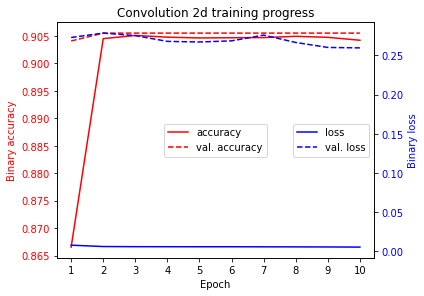

In [27]:
training_progress_plot(fit_results, title='Convolution 2d training progress',
                       save_file='ml_class_images/training_progress.png')

## Predictions
---

In [28]:
# find best accuracy values in given prediction threshold values
pred_thrs = np.arange(0.2, 0.6, 0.0001)
pred_thrs

array([0.2   , 0.2001, 0.2002, ..., 0.5997, 0.5998, 0.5999])

In [29]:
# accuracy measure for flattened zero-one arrays
def binary_flatten_accuracy(y_true, y_pred):
    cm = tf.math.confusion_matrix(y_true.flatten(), y_pred.flatten()).numpy()
    return float(np.sum(np.diag(cm)))/np.sum(np.sum(cm))

# accuracy measure for labeled (different length) arrays
def exact_match_ratio(y_true, y_pred):
    matches = 0.
    for y_t, y_p in zip(y_true, y_pred):
        if np.array_equal(sorted(y_t), sorted(y_p)):
            matches += 1.
    return matches/y_true.shape[0]

# accuracy measure for labeled (different length) arrays
def multilabel_accuracy(y_true, y_pred):
    score = 0.
    for y_t, y_p in zip(y_true, y_pred):
        score += np.float32(np.size(np.intersect1d(y_t, y_p)))/np.size(np.union1d(y_t, y_p))
    
    return score/y_true.shape[0]

In [30]:
def accuracy_depencies(labels, logits, thr_s, save_file=None):
    dependencies = list([])
    for thr in tqdm(thr_s):
        y_true = np.array(labels)
        y_pred = np.array([np.vectorize(lambda p: 1 if p>=thr else 0)(l) for l in logits])
        
        num_y_true = np.array([np.where(l==1)[0] for l in y_true])
        num_y_pred = np.array([np.where(l==1)[0] for l in y_pred])
        
        bf_acc = binary_flatten_accuracy(y_true, y_pred)
        emr = exact_match_ratio(num_y_true, num_y_pred)
        ml_acc = multilabel_accuracy(num_y_true, num_y_pred)
        
        dependencies.append([thr, bf_acc, emr, ml_acc])
    
    # build dataframe
    df = pd.DataFrame(dependencies,
                      columns=['threshold', 'flat. acc.', 'em. ratio', 'ml. acc.'])
    df = df.set_index('threshold')
    
    if save_file:
        df.to_csv(save_file)
    return df

In [31]:
acc_dep = accuracy_depencies(labels=y_test, logits=predictions, thr_s=pred_thrs,
                             save_file='ml_class_images/accuracy_depencies.csv')
acc_dep

,flat. acc.,em. ratio,ml. acc.
threshold,,,
0.2000,0.865476,0.029913,0.262771
0.2001,0.865642,0.029913,0.262893
0.2002,0.865697,0.029913,0.262774
0.2003,0.865789,0.029913,0.262738
0.2004,0.865881,0.029913,0.262860
...,...,...,...
0.5995,0.911993,0.000000,0.000000
0.5996,0.911993,0.000000,0.000000
0.5997,0.911993,0.000000,0.000000


In [32]:
def accuracy_dependecies_plot(df, title, save_file=None):
    plt.figure(figsize=(16, 4))
    
    x_space = df.index.values
    plt.plot(x_space, df['flat. acc.'].values, label='flattened accuracy')
    plt.plot(x_space, df['em. ratio'].values, label='exact match ratio')
    plt.plot(x_space, df['ml. acc.'].values, label='multilabel accuracy')
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction threshold')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

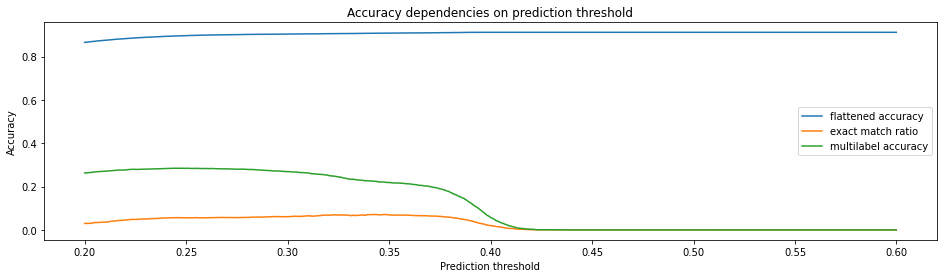

In [33]:
accuracy_dependecies_plot(acc_dep, title='Accuracy dependencies on prediction threshold',
                          save_file='ml_class_images/accuracy_depencies.png')

In [34]:
print(f'Max flattened binary accuracy {np.round(acc_dep["flat. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["flat. acc."].argmax()], 4)} prediction threshold.')
print(f'Max exact match ratio {np.round(acc_dep["em. ratio"].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["em. ratio"].argmax()], 4)} prediction threshold.')
print(f'Max multilabel accuracy {np.round(acc_dep["ml. acc."].max(), 4)}' +
      f' for {np.round(acc_dep.index[acc_dep["ml. acc."].argmax()], 4)} prediction threshold.')

Max flattened binary accuracy 0.9123 for 0.4036 prediction threshold.
Max exact match ratio 0.0713 for 0.343 prediction threshold.
Max multilabel accuracy 0.2849 for 0.2452 prediction threshold.


In [39]:
PRED_THR = 0.2452

In [40]:
predictions_zero_one = np.array([[1 if v>=PRED_THR else 0 for v in p] for p in predictions])

In [43]:
def get_labels(zero_ones, labels):
    ones = np.where(zero_ones==1)
    return labels[ones]

def jaccard_sim(l1, l2):
    inters = np.intersect1d(l1, l2)
    union = np.union1d(l1, l2)
    return np.float32(np.size(inters))/np.size(union)

def images_matrix_plot(images, y_true, y_pred, dim=(3, 4), save_file=None):
    fig = plt.figure(figsize=(4*dim[1], 4*dim[0]))
    
    for i in range(dim[0]*dim[1]):
        img_fig = fig.add_subplot(dim[0], dim[1], i + 1)
        img_fig.imshow(images[i].reshape(prim_X_shape))
        
        labels = get_labels(y_true[i], np.arange(np.size(classes)))
        logits = get_labels(y_pred[i], np.arange(np.size(classes)))
        title = plt.title(f'P/R: {logits}/{labels}')
        js = jaccard_sim(labels, logits)  # jaccard similarity of labels and logits
        c = 'r' if js<0.3333 else 'g' if js>0.6666 else 'b'
        plt.setp(title, color=c)
        
        img_fig.axes.get_xaxis().set_visible(False)
        img_fig.axes.get_yaxis().set_visible(False)
        plt.tight_layout()
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

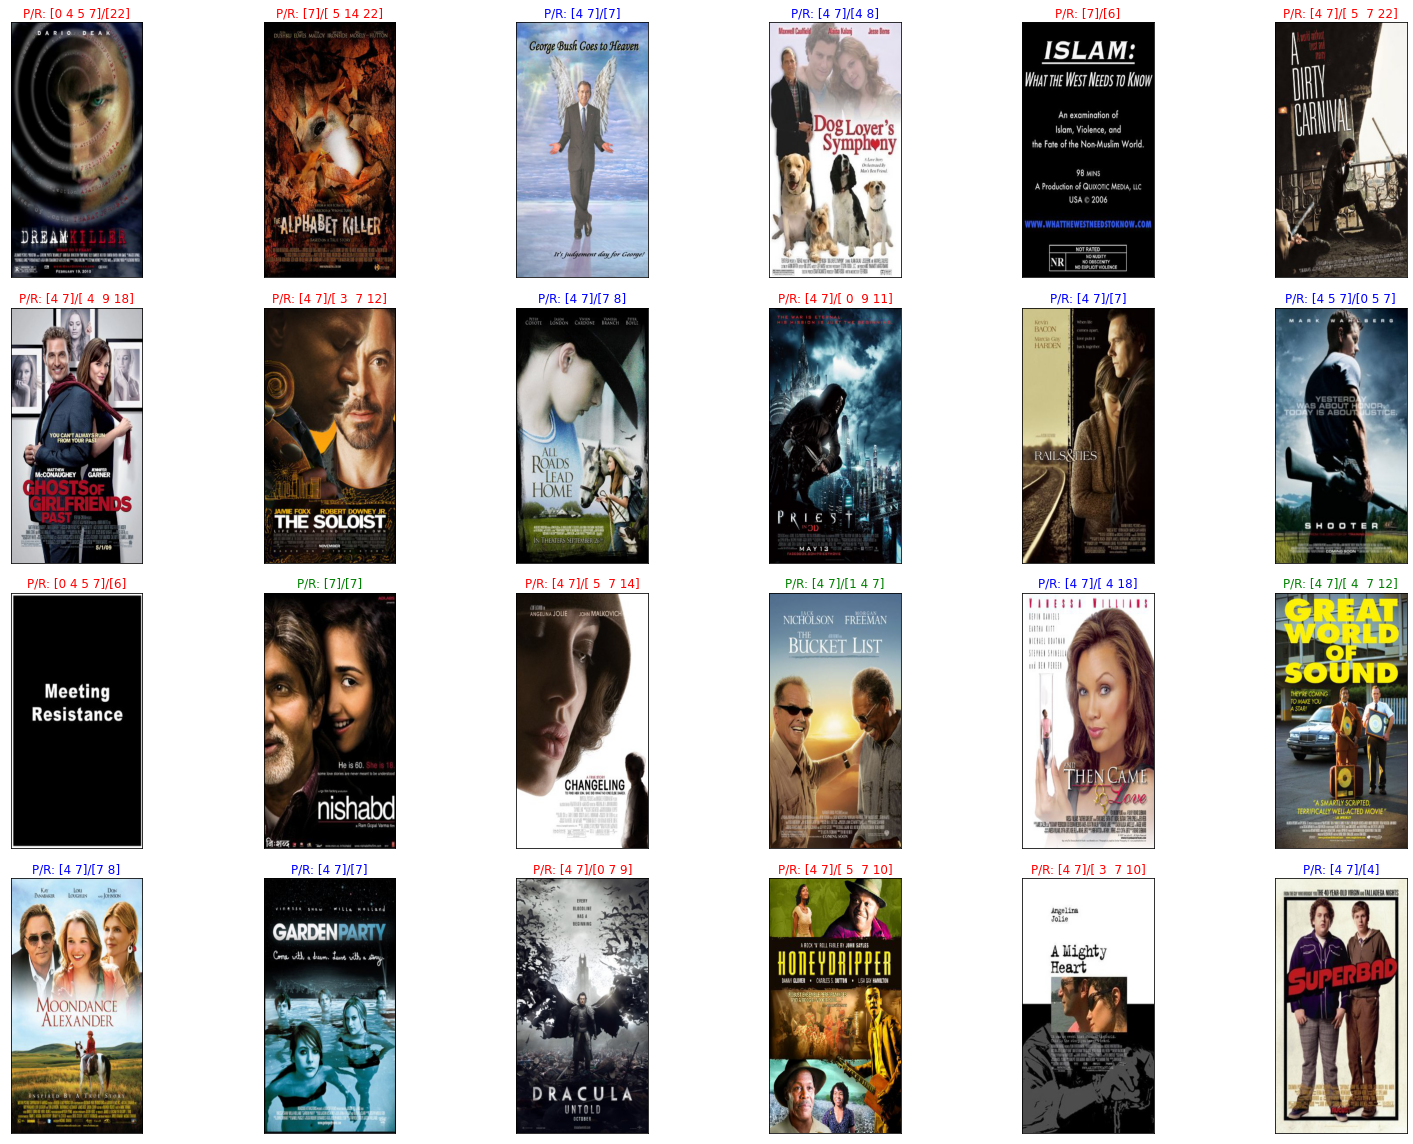

P - predicted | R - real
{0: 'Action', 1: 'Adventure', 2: 'Animation', 3: 'Biography', 4: 'Comedy', 5: 'Crime', 6: 'Documentary', 7: 'Drama', 8: 'Family', 9: 'Fantasy', 10: 'History', 11: 'Horror', 12: 'Music', 13: 'Musical', 14: 'Mystery', 15: 'N/A', 16: 'News', 17: 'Reality-TV', 18: 'Romance', 19: 'Sci-Fi', 20: 'Short', 21: 'Sport', 22: 'Thriller', 23: 'War', 24: 'Western'}


In [44]:
images_matrix_plot(X_test, y_test, predictions_zero_one, dim=(4, 6),
                   save_file='ml_class_images/prediction_examples.png')

print('P - predicted | R - real')
print(dict(zip(np.arange(np.size(classes)), classes)))